<a href="https://colab.research.google.com/github/selcuk-yalcin/TrustworthyML/blob/main/(Gradcam)XAI_Gradient_based_XAI_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ----------- Preprocessing and Model Setup -----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load pre-trained model (e.g., ResNet50)
model = models.resnet50(pretrained=True).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Choose the target layer (last conv layer in ResNet50)
target_layer = model.layer4[-1]

In [ ]:
# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0).to(device)
def load_original_image(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    return np.array(img)


In [ ]:
# ----------- Grad-CAM Core Logic -----------

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hook the forward and backward pass
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # ----------- Step 1: Compute Gradients of Class Score -----------
        score = output[0, class_idx]
        self.model.zero_grad()
        score.backward()

        # ----------- Step 2: Calculate Importance Weights (αᶜₖ) -----------
        grads = self.gradients  # [B, C, H, W]
        pooled_grads = torch.mean(grads, dim=[2, 3])  # Global average pooling

        # ----------- Step 3: Combine Feature Maps and Apply ReLU -----------
        activations = self.activations  # [B, C, H, W]
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_grads[:, i].unsqueeze(-1).unsqueeze(-1)

        heatmap = torch.sum(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)  # Apply ReLU to focus on positive contributions

        # Normalize and convert to NumPy
        heatmap = heatmap.cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

        return heatmap, class_idx

In [ ]:
def overlay_heatmap(heatmap, image_path, alpha=0.3):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

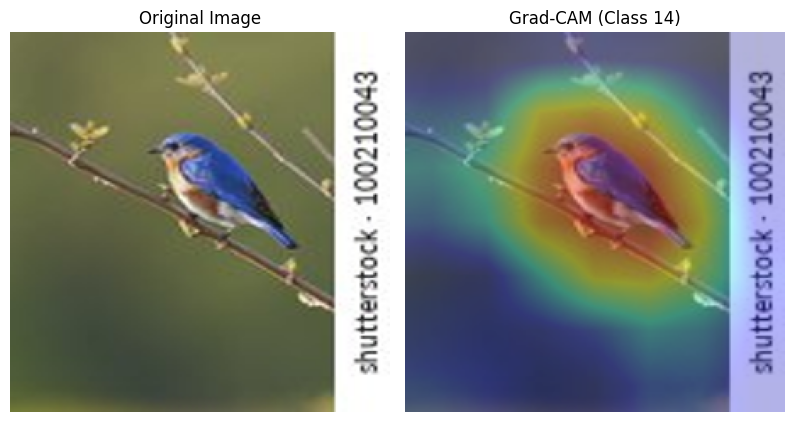

In [ ]:
# ----------- Run on Example Image -----------

# Set your image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Thurstworthy Machine Learning Exercises/Thurstworthy Medium Codes/images/kus.jpg"


# Generate Grad-CAM heatmap and overlay
input_tensor = load_image(image_path)
gradcam = GradCAM(model, target_layer)
heatmap, class_id = gradcam(input_tensor)
overlay = overlay_heatmap(heatmap, image_path)

# Load original image for comparison
original_image = load_original_image(image_path)

# ----------- Plot: Side-by-Side Comparison -----------
# ----------- Side-by-Side Plot with Colorbar -----------
plt.figure(figsize=(12, 5))

# Left: Original
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Middle: Grad-CAM Overlay
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM (Class {class_id})")
plt.axis("off")


plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


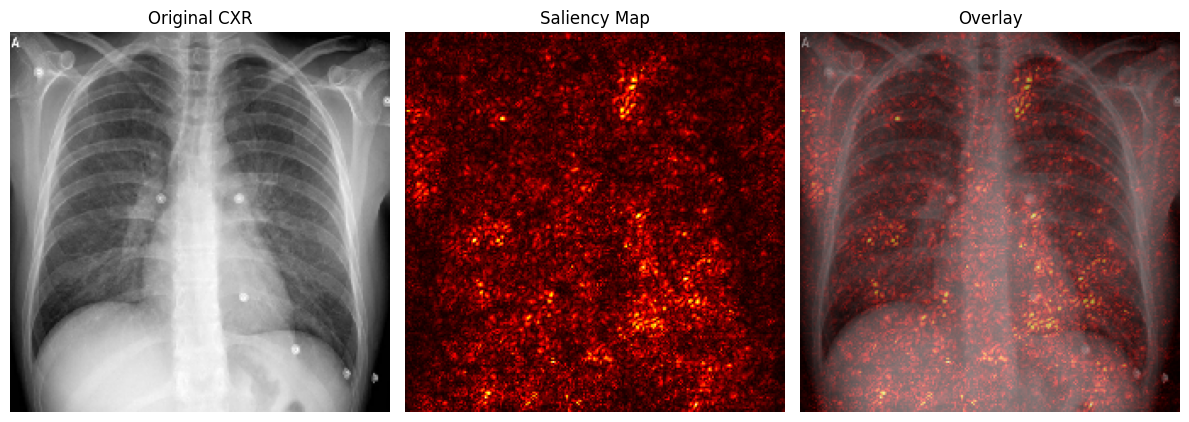

Top predicted class index: 111
Prediction confidence: 0.5984992


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


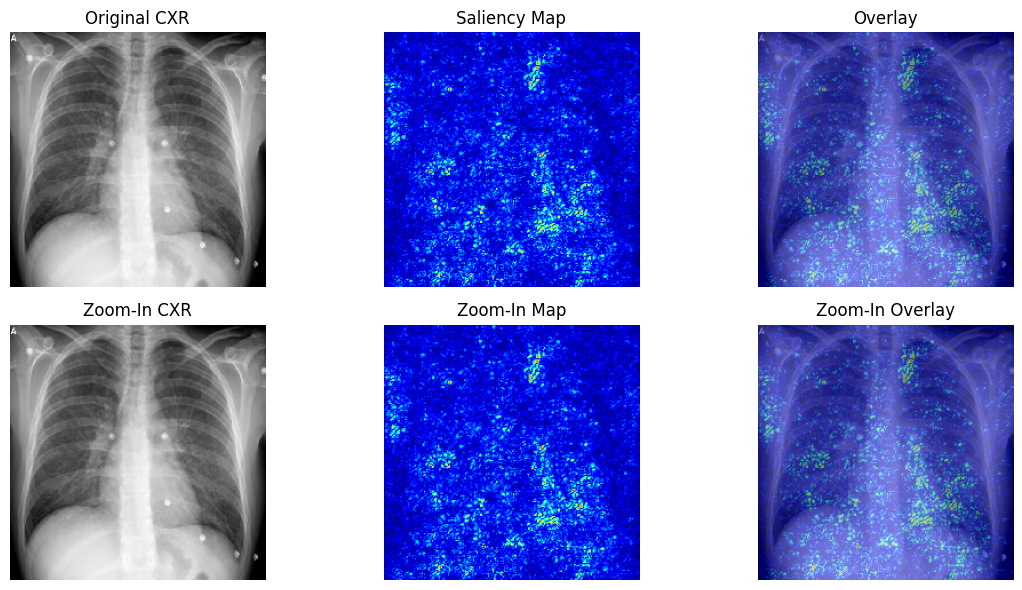

Top predicted class index: 111
Prediction confidence: 0.5984992


In [ ]:
#pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

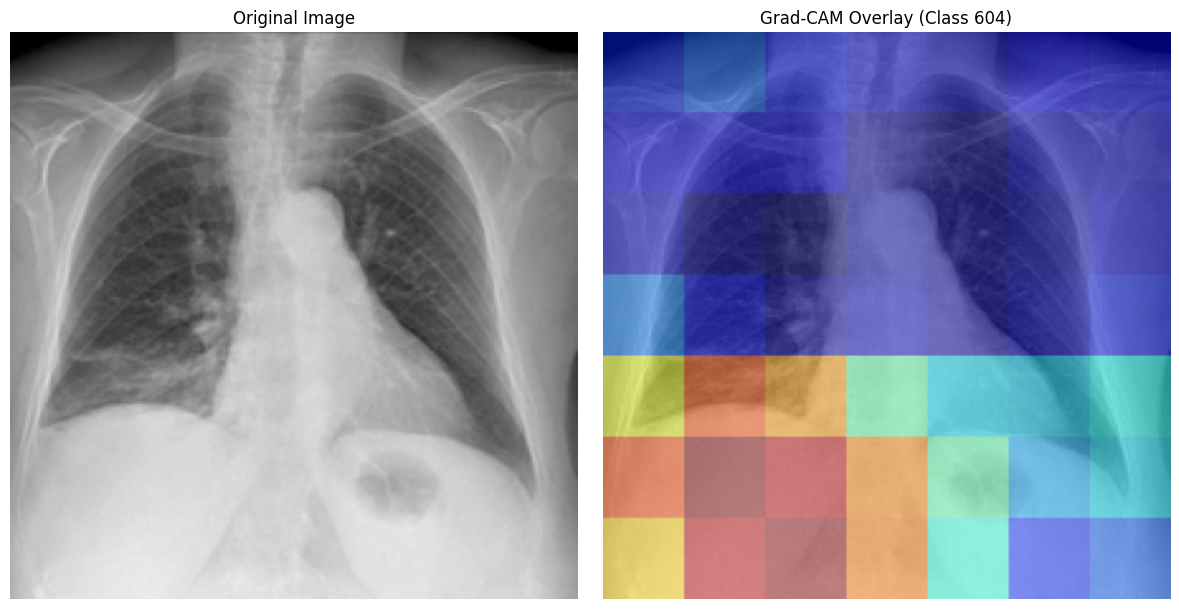